In [2]:
%reload_ext autoreload
%autoreload 2
from core.utils import Path, AnnotatedImage
from core import utils
import numpy as np
import typing as tp
from matplotlib import pyplot as plt
import itertools

from PIL import Image

In [89]:
def show_image(path: Path):
    plt.imshow(utils.parse_image(path))

# Eigencat

Yu Tomita and John McCloskey

# Outline

- Motivation

- Cat Dataset Overview

- Program Flow

- Data Cleaning (Cat Aligners)

- Singular Value Decomposition

- Results

- Conclusion / Future Directions

# Motivation

## Eigenface

![my image](images_yu/eigeneyes.png)

L. Sirovich; M. Kirby (1987). "Low-dimensional procedure for the characterization of human faces". <i>Journal of the Optical Society of America</i> A. <b>4</b> (3): 519–524.

![my image](images_yu/eigenfaces.png)

![my image](images_yu/cuties.png)

# Cat Dataset

- kaggle (https://www.kaggle.com/crawford/cat-dataset)

[Point(x=115, y=122),
 Point(x=179, y=121),
 Point(x=133, y=169),
 Point(x=95, y=70),
 Point(x=93, y=17),
 Point(x=131, y=46),
 Point(x=233, y=39),
 Point(x=281, y=9),
 Point(x=224, y=69)]

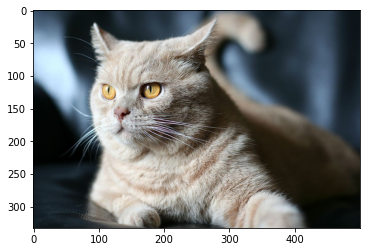

In [3]:
cat_path = utils.Paths.INPUT_PATH / "CAT_00" / "00000001_012.jpg"
cat = AnnotatedImage.from_image_path(cat_path)

show_image(cat.image)
cat.points

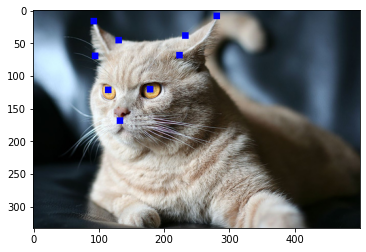

In [4]:
def load_cat_with_points(path):
    cat = AnnotatedImage.from_image_path(cat_path)
    temp_cat = utils.parse_image(cat.image)

    for point in cat.points:
        # NOTE that x and y are flipped!
        temp_cat[point.y-5: point.y+5, point.x-5: point.x+5] = [0,0,255]
        
    return temp_cat


cat_path = utils.Paths.INPUT_PATH / "CAT_00" / "00000001_012.jpg"
plt.imshow(load_cat_with_points(cat_path))

## Program Flow


![title](images_yu/cat_flow.png)

# Data Cleaning

### 3 methods for comparison


1. Simple (`CatAlignerSimple`)
2. Using eyes (`CatAlignerEyes`)
3. Using 9 points (`CatAlignerLSTSQ`)

#### `CatAlignerSimple`

- Crop to the smallest image that contains 9 points, then scale to 100 x 100.

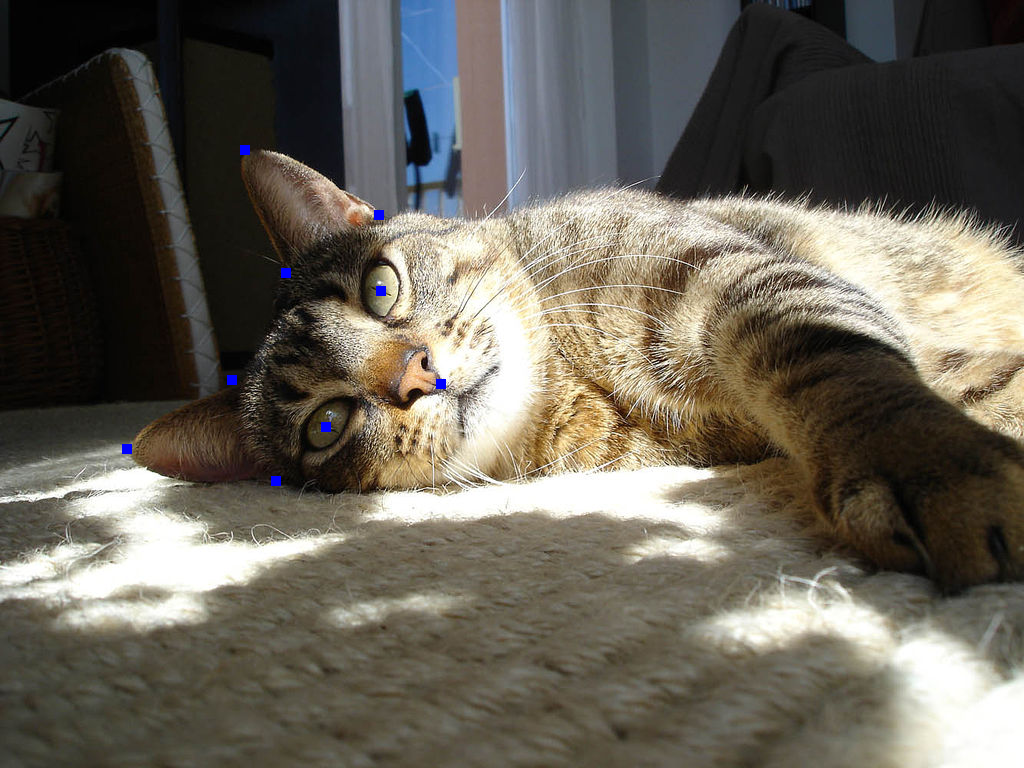

In [6]:
cat_path = utils.Paths.INPUT_PATH / "CAT_05" / "00001289_022.jpg"

cat = load_cat_with_points(cat_path)
img = Image.fromarray(cat.astype(np.uint8))
display(img)

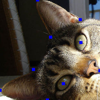

In [9]:
cat_path = utils.Paths.INPUT_PATH / "CAT_05" / "00001289_022.jpg"
cat = AnnotatedImage.from_image_path(cat_path)

def truncate_by_all_points(
    img: Image.Image,
    points: tp.List[tp.List[int]],
    *,
    width: int,
    height: int,
) -> Image.Image:
    xs, ys = zip(*points)
    cropped = img.crop((min(xs), min(ys), max(xs), max(ys)))
    return cropped.resize((width, height))

new_img = truncate_by_all_points(img, cat.points, width=100, height=100)
display(new_img)

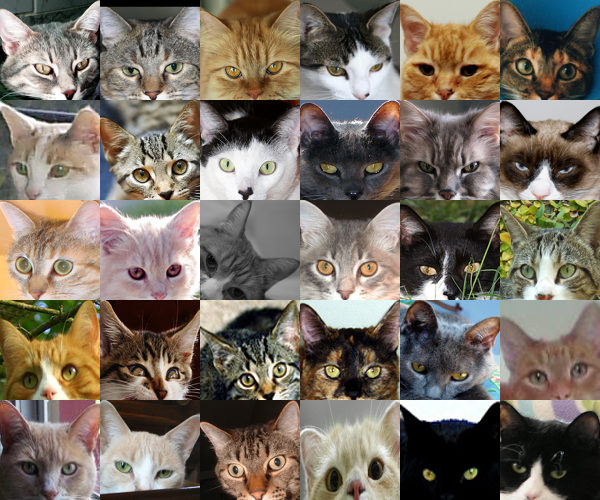

In [7]:
from core.cat_aligner import CatAlignerSimple, stack_images

aligned = tuple(CatAlignerSimple.gen_aligned(n=30, width=100, height=100))
many_cats = stack_images(aligned)
display(many_cats)

#### `CatAlignerEyes`

- Set eyes to static locations. Crop with margings from eyes.

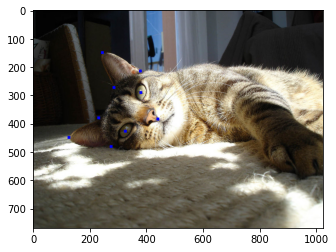

In [20]:
plt.imshow(load_cat_with_points(cat_path))

![title](images_yu/angled0.png)

![title](images_yu/angled1.png)

![title](images_yu/angled2.png)

![title](images_yu/angled4.png)

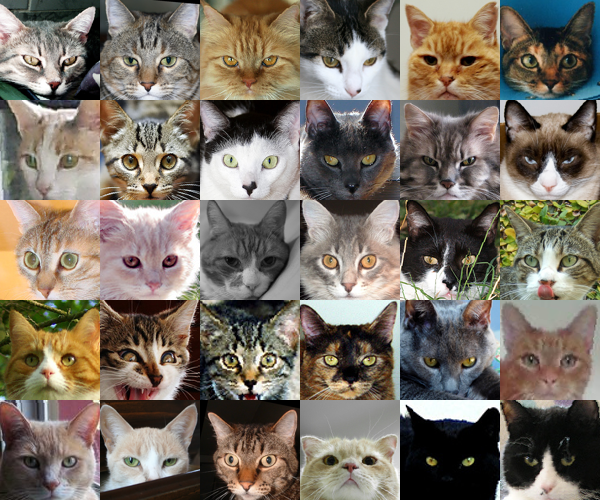

In [8]:
from core.cat_aligner import CatAlignerEyes, stack_images

aligned = tuple(CatAlignerEyes.gen_aligned(n=30, width=100, height=100))
many_cats = stack_images(aligned)
display(many_cats)

#### `CatAlignerLSTSQ`

1 Choose a standard cat.

2 Transform other cats to put their 9 points closer to the standard.

- Choose a "standard" cat, and find the coordinates
![title](images_yu/standard_cat.png)

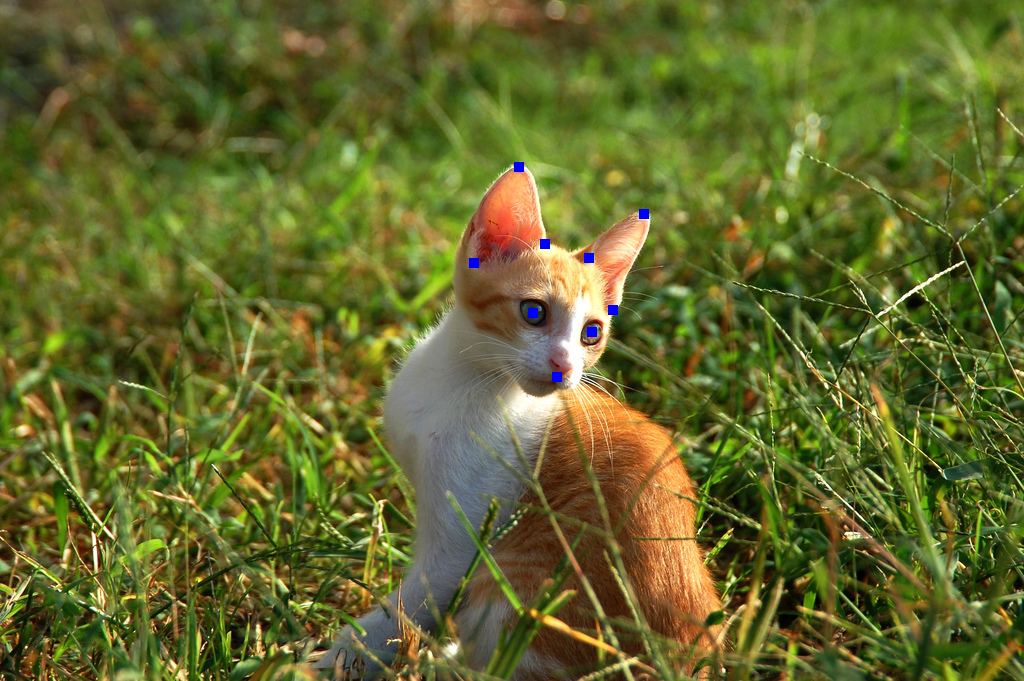

In [5]:
cat_path = utils.Paths.INPUT_PATH / "CAT_00" / "00000038_020.jpg"
cat = load_cat_with_points(cat_path)
img = Image.fromarray(cat.astype(np.uint8))
display(img)

![title](images_yu/9_0.png)

![title](images_yu/9_1.png)

![title](images_yu/2x2matrix.png)

"A" is a 2x2 matrix for linear transformation. It can (1) rotate and (2) scale the (x,y) cordinates.

![title](images_yu/svd_ellipse.png)

How about <b>(3) translation</b>?

We can add another dimension

![title](images_yu/3x3matrix.png)

array([[302, 302, 413, 253,  92, 185, 187,  94, 255],
       [466, 634, 556, 359, 334, 463, 630, 751, 727]])

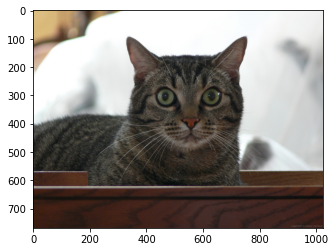

In [179]:
standard_cat_path = utils.Paths.INPUT_PATH / "CAT_00" / "00000055_003.jpg"
standard_cat = AnnotatedImage.from_image_path(standard_cat_path)

standard_points = utils.Point.to_np(standard_cat.points)[:, [1, 0]].T # flip x and y

show_image(standard_cat.image)
standard_points

array([[313, 332, 377, 263, 167, 244, 258, 214, 310],
       [533, 592, 557, 474, 519, 545, 589, 644, 613]])

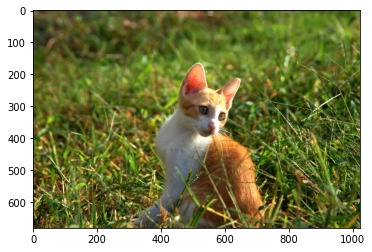

In [99]:
test_cat_path = utils.Paths.INPUT_PATH / "CAT_00" / "00000038_020.jpg"
test_cat = AnnotatedImage.from_image_path(test_cat_path)

test_points = utils.Point.to_np(test_cat.points)[:, [1, 0]].T # flip x and y
show_image(test_cat.image)
test_points

In [103]:
# add row of 1s to make support translation by multiplication

one_col = np.ones((1, 9))

standard = np.append(standard_points, one_col, 0)
test = np.append(test_points, one_col, 0)
test

array([[313., 332., 377., 263., 167., 244., 258., 214., 310.],
       [533., 592., 557., 474., 519., 545., 589., 644., 613.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]])

In [160]:
from numpy import linalg 

# test.T @ x = standard.T
#   A @ test ~= standard
x, residuals, rank, singlar = linalg.lstsq(a=test.T, b=standard.T, rcond=None) # a @ x = b
A = x.T
A

array([[ 1.59583670e+00, -5.27344089e-01,  8.88935336e+01],
       [ 4.81012274e-01,  2.71601980e+00, -1.11458942e+03],
       [ 1.86316248e-15, -9.16367676e-16,  1.00000000e+00]])

In [161]:
# transformed points
np.rint(A @ test).astype(int)

array([[307, 307, 397, 259,  82, 191, 190,  91, 260],
       [484, 653, 580, 299, 375, 483, 609, 737, 699],
       [  1,   1,   1,   1,   1,   1,   1,   1,   1]])

In [162]:
standard

array([[302., 302., 413., 253.,  92., 185., 187.,  94., 255.],
       [466., 634., 556., 359., 334., 463., 630., 751., 727.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]])

To apply this matrix to the whole image, we need to get all cordinates for each pixel

In [163]:
rgb_pixels = utils.parse_image(test_cat.image)
rgb_pixels

array([[[100,  91,  62],
        [ 99,  92,  64],
        [101,  95,  69],
        ...,
        [ 93, 113,  28],
        [ 91, 114,  26],
        [ 92, 115,  27]],

       [[ 99,  92,  64],
        [ 99,  92,  64],
        [100,  93,  67],
        ...,
        [ 92, 114,  29],
        [ 92, 116,  28],
        [ 93, 117,  29]],

       [[ 99,  93,  67],
        [100,  94,  68],
        [102,  94,  71],
        ...,
        [ 94, 119,  28],
        [ 94, 121,  28],
        [ 93, 122,  29]],

       ...,

       [[ 89,  62,  19],
        [133, 116,  62],
        [ 78,  62,  10],
        ...,
        [116, 127,  58],
        [116, 126,  57],
        [117, 124,  57]],

       [[129,  49,  22],
        [127,  78,  46],
        [ 65,  49,  13],
        ...,
        [116, 126,  55],
        [119, 127,  54],
        [128, 131,  60]],

       [[193, 113,  78],
        [134,  70,  42],
        [ 84,  58,  21],
        ...,
        [108, 117,  52],
        [121, 127,  55],
        [127, 128,  60]]

In [164]:
rgb_pixels.shape

(681, 1024, 3)

In [165]:
def _get_coordinates(test_cat_image: np.array):
    h, w, _ = test_cat_image.shape
    points_gen = itertools.product(range(1, h + 1), range(1, w + 1))
    
    coordinates_2d = np.array(list(points_gen)).T

    # add column with ones for translation
    return np.append(coordinates_2d, np.ones((1, h * w)), 0).astype(int)


points_from = _get_coordinates(rgb_pixels)
points_from

array([[   1,    1,    1, ...,  681,  681,  681],
       [   1,    2,    3, ..., 1022, 1023, 1024],
       [   1,    1,    1, ...,    1,    1,    1]])

In [174]:
# Apply the same transformation matrix for all coordinates

points_to = np.rint(A @ points_from).astype(int)
points_to = np.clip(points_to, a_min=0, a_max=1024) # remove outside boundary

points_to

array([[  90,   89,   89, ...,  637,  636,  636],
       [   0,    0,    0, ..., 1024, 1024, 1024],
       [   1,    1,    1, ...,    1,    1,    1]])

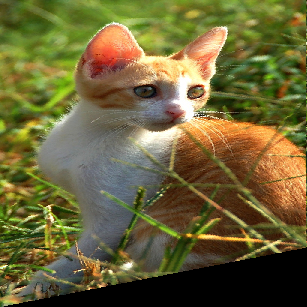

In [175]:
# remove third row, then coordinates -> index
src_xy = points_from[:2, :] - 1
new_xy = ((points_to[:2, :] - 1) * 0.3).astype(int)

# separate into two vectors
src_x, src_y = src_xy[0, :], src_xy[1, :]
dst_x, dst_y = new_xy[0, :], new_xy[1, :]

final_image = np.zeros([dst_x.max() + 1, dst_y.max() + 1, 3]).astype(int)

# Copy RGB from the source coordinates to the destination
final_image[dst_x, dst_y] = rgb_pixels[src_x, src_y]
img = Image.fromarray(final_image.astype(np.uint8))
display(img)

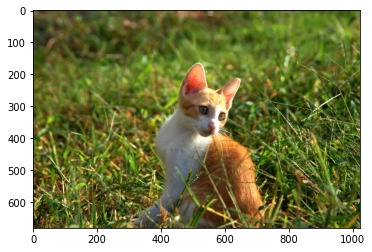

In [176]:
show_image(test_cat.image)

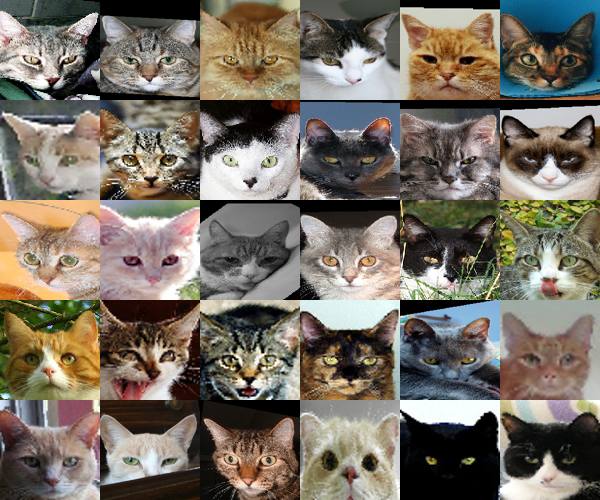

In [9]:
from core.cat_aligner import CatAlignerLSTSQ, stack_images

aligned = tuple(CatAlignerLSTSQ.gen_aligned(n=30, width=100, height=100))
many_cats = stack_images(aligned)
display(many_cats)